# Liveness-Tracking Results

Here are the results for the liveness tests.

## 1. Imports

Import the libraries to process the data

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from math import prod
import os

## 2. Read Data

Read in the data for each test result.

In [22]:
# The data is stored in a 5XX.csv for the serial tests, and 6XX.csv for the parallel tests
# The data files are in the `/data` folder


# A structure for storing the data
all_data = {}

for i in range(500, 600):
    if os.path.isfile("data/liveness-test/" + str(i) + ".csv"):
        all_data[i] = pd.read_csv("data/liveness-test/" + str(i) + ".csv")
        print("Loaded data for test " + str(i))

Loaded data for test 500
Loaded data for test 501


In [23]:
class Object:
    def __init__(self, allocation):
        self.allocation = allocation
        self.data = []

    def __hash__(self):
        # An object is uniquely identified by its allocation address, and the intervals it was alive for
        return hash((self.allocation.address, self.get_first_interval(), self.get_last_interval()))
    
    def get_address(self):
        return self.allocation.address

    def get_site(self):
        return self.allocation.site

    def was_written_to_during_interval(self, interval):
        '''
        Was this object written to during the given interval
        '''
        return sum([int(row["Written During This Interval?"]) for row in self.data if row["Interval #"] == interval])

    def get_data_after_last_write(self):
        '''
        Get the data after the last write to this object

        If the object was never written to, this will return the entire data
        '''
        result = []
        for row in self.data:
            if row["Written During This Interval?"]:
                result = []
            else:
                result.append(row)
        assert sum([1 for row in result if row["Written During This Interval?"]]) == 0
        last_write = self.get_interval_of_last_write()
        assert len(result) == 0 or result[0]["Interval #"] == last_write + 1 or last_write == -1
        return result
    
    def get_data_for_longest_lifetime_without_write(self):
        '''
        Get the data for the longest lifetime without a write to this object

        If this object was always written to, this will return an empty list
        '''

        longest_contiguous = 0
        current_contiguous = 0

        result = []
        for i, row in enumerate(self.data):
            if not row["Written During This Interval?"]:
                current_contiguous += 1
            else:
                if current_contiguous > longest_contiguous:
                    result = self.data[i-current_contiguous:i]
                    longest_contiguous = current_contiguous

                current_contiguous = 0

        if current_contiguous > longest_contiguous:
            result = self.data[-current_contiguous:]
            longest_contiguous = current_contiguous


        assert len(result) == self.get_longest_lifetime_without_write()
        assert len(result) == longest_contiguous
        assert sum([1 for row in result if row["Written During This Interval?"]]) == 0

        return result


    def get_average_compression_savings_in_bytes(self):
        '''
        Get the average amount of memory saved by compressing the physical pages in bytes
        '''
        avg = 0
        for row in self.data:
            interval_savings = row["Object Physical Page Compression Savings (bytes)"]
            avg += interval_savings
        return avg / len(self.data)
    
    def get_average_compression_savings_after_last_write_in_bytes(self):
        '''
        Get the amount of memory saved by compressing the physical pages after the last write in bytes
        '''
        data_after_last_write = self.get_data_after_last_write()
        savings = 0
        for row in data_after_last_write:
            savings += row["Object Physical Page Compression Savings (bytes)"]
        if savings == 0 or len(data_after_last_write) == 0:
            return 0
        savings /= len(data_after_last_write)
        return savings
    
    def get_average_compression_during_longest_lifetime_without_write_in_bytes(self):
        '''
        Get the average amount of memory saved by compressing the physical pages during the longest lifetime without a write in bytes
        '''
        data = self.get_data_for_longest_lifetime_without_write()
        if len(data) == 0:
            return 0
        return sum([row["Object Physical Page Compression Savings (bytes)"] for row in data]) / len(data)

    def get_virtual_size_in_bytes(self):
        '''
        Get the size of virtual memory occupied by the object in bytes
        '''
        return self.data[0]["Object Virtual Size (bytes)"]

    def get_physical_size_in_bytes(self):
        '''
        Get the size of physical pages occupied by the object in bytes
        '''
        return self.data[0]["Object Physical Size (bytes)"]
    
    def get_first_interval(self):
        '''
        Get the first interval this object was alive for
        '''
        return self.data[0]["Interval #"]
    
    def get_last_interval(self):
        '''
        Get the last interval this object was alive for
        '''
        return self.data[-1]["Interval #"]
    
    def get_lifetime_intervals(self):
        '''
        How long did this object live for (in intervals)
        '''
        # Get the maximum age of the object
        return len(self.data)
    
    def get_total_intervals_with_write(self):
        '''
        Get the total number of intervals this object was written to
        '''
        return sum([1 for row in self.data if row["Written During This Interval?"]])

    def get_total_intervals_without_write(self):
        '''
        Get the total number of intervals this object was not written to
        '''
        return sum([1 for row in self.data if not row["Written During This Interval?"]])

    def get_interval_of_last_write(self, interval=None):
        '''
        Get the interval number of the last write to this object

        If the object was never written to, this will return -1
        '''
        if interval is not None:
            for row in self.data[::-1]:
                if row["Interval #"] <= interval and row["Written During This Interval?"]:
                    return row["Interval #"]
            return -1

        for row in self.data[::-1]:
            if row["Written During This Interval?"]:
                return row["Interval #"]
        return -1
    
    def get_longest_lifetime_without_write(self):
        '''
        Get the longest number of continuous intervals without a write to this object
        '''
        longest = 0
        current = 0
        for row in self.data:
            if not row["Written During This Interval?"]:
                current += 1
            else:
                longest = max(longest, current)
                current = 0
        return max(longest, current)
    
    def get_lifetime_after_last_write(self):
        '''
        Get the number of intervals this object lived for after the last write

        If the object was never written to, this will return the same as `get_lifetime_intervals`
        '''
        if self.get_interval_of_last_write() == -1:
            return self.get_lifetime_intervals()
        return self.get_last_interval() - self.get_interval_of_last_write()

    def add_row(self, row):
        self.data.append(row)

    def __str__(self):
        result = "Object: " + str(self.allocation.address) + "\n"
        result += "  Allocation Site: " + str(self.allocation.site) + "\n"
        result += "  Size:\n"
        result += "    Virtual: " + str(self.get_virtual_size_in_bytes()) + " bytes\n"
        result += "    Physical: " + str(self.get_physical_size_in_bytes()) + " bytes\n"
        result += "    Avg. physical compression savings throughout lifetime: " + str(self.get_average_compression_savings_in_bytes()) + " bytes\n"
        result += "    Avg. physical compression savings after last write: " + str(self.get_average_compression_savings_after_last_write_in_bytes()) + " bytes\n"
        result += "    Avg. physical compression savings throughout longest clean streak: " + str(self.get_average_compression_during_longest_lifetime_without_write_in_bytes()) + " bytes\n"
        result += "  First interval: " + str(self.get_first_interval()) + "\n"
        result += "  Last interval: " + str(self.get_last_interval()) + "\n"
        result += "  Lifetime: " + str(self.get_lifetime_intervals()) + "\n"
        result += "  Interval of last write: " + str(self.get_interval_of_last_write()) + "\n"
        result += "  Longest lifetime without write: " + str(self.get_longest_lifetime_without_write()) + "\n"
        result += "  Lifetime after last write: " + str(self.get_lifetime_after_last_write()) + "\n"
        result += "  Total intervals with write: " + str(self.get_total_intervals_with_write()) + "\n"
        result += "  Total clean intervals: " + str(self.get_total_intervals_without_write()) + "\n"
        return result

    def __repr__(self):
        return str(self.get_address()) + " [Interval #" + str(self.get_first_interval()) + " - #" + str(self.get_last_interval()) + "]"

class Address:
    def __init__(self, address, site):
        self.address = address
        self.site = site
        self.associated_objects = []

    def get_objects(self):
        return self.associated_objects

    def add_row(self, row):
        if row["Is new?"]:
            self.associated_objects.append(Object(self))
        self.associated_objects[-1].add_row(row) 

    def __str__(self):
        result = "Address: " + str(self.address) + "\n"
        for obj in self.associated_objects:
            result += str(obj) + "\n"
        return result

    def __repr__(self):
        return str(self)

## 3. Process Results

Go through the data and process some results.

## 3.1 New, Stale, and Hot Allocations

This graphs the number of live objects each iteration, the number of new objects allocated that iteration, and the objects that were written to that iteration. The ages of the objects are also denoted by the color, and the brightness indicates the compression savings.

### 3.1.1 Divide the data into information about each object

In [24]:
# Get the tests from the data
tests = list(all_data.keys())
# Get the number of tests
print("Number of tests: " + str(len(tests)))

test_allocation_data = {}

# Iterate over the tests and graph the results
for test in tests:
    # Get the data for the test
    test_data = all_data[test]

    # For each test interval, make the data keyed on each object's address.
    # If it is reallocated (its "Is new?" column is set), treat it as a new allocation.
    allocation_data = {}
    for index, row in test_data.iterrows():
        address = row["Object Address"]
        site = row["Allocation Site"]
        if address not in allocation_data:
            allocation_data[address] = Address(address, site)
        allocation_data[address].add_row(row)

    # Store the allocation data for this test
    test_allocation_data[test] = allocation_data

for test_number, allocation_data in test_allocation_data.items():
    print("Test " + str(test_number))
    for address, address_data in allocation_data.items():
        print(str(address_data))

Number of tests: 2
Test 500
Address: 0x7F0BB30807E0
Object: 0x7F0BB30807E0
  Allocation Site: 0x7F0BB3893011
  Size:
    Virtual: 32 bytes
    Physical: 4096 bytes
    Avg. physical compression savings throughout lifetime: 4050.0 bytes
    Avg. physical compression savings after last write: 4050.0 bytes
    Avg. physical compression savings throughout longest clean streak: 4050.0 bytes
  First interval: 2
  Last interval: 22
  Lifetime: 21
  Interval of last write: 2
  Longest lifetime without write: 20
  Lifetime after last write: 20
  Total intervals with write: 1
  Total clean intervals: 20


Address: 0x7F0BB2E80500
Object: 0x7F0BB2E80500
  Allocation Site: 0x7F0BB3A3EC02
  Size:
    Virtual: 96 bytes
    Physical: 4096 bytes
    Avg. physical compression savings throughout lifetime: 3989.0 bytes
    Avg. physical compression savings after last write: 3989.0 bytes
    Avg. physical compression savings throughout longest clean streak: 3989.0 bytes
  First interval: 2
  Last interval:

### 3.1.2 Graph the data

Test 500
    Interval #  Total Objects  Total Written  Total New  Written  New  \
0            2              6              6          6        1    1   
1            3              7              4          0        0    0   
2            4              8              5          0        0    0   
3            5              9              5          0        0    0   
4            6             10              6          0        0    0   
..         ...            ...            ...        ...      ...  ...   
6           18             22             18          0        0    0   
7           19             23             18          0        0    0   
8           20             24             20          0        0    0   
9           21             25             21          0        0    0   
10          22             25             15          0        0    0   

    Percent Savings  Savings  Savings Without Writes  \
0          0.000000     4050                       0   
1 

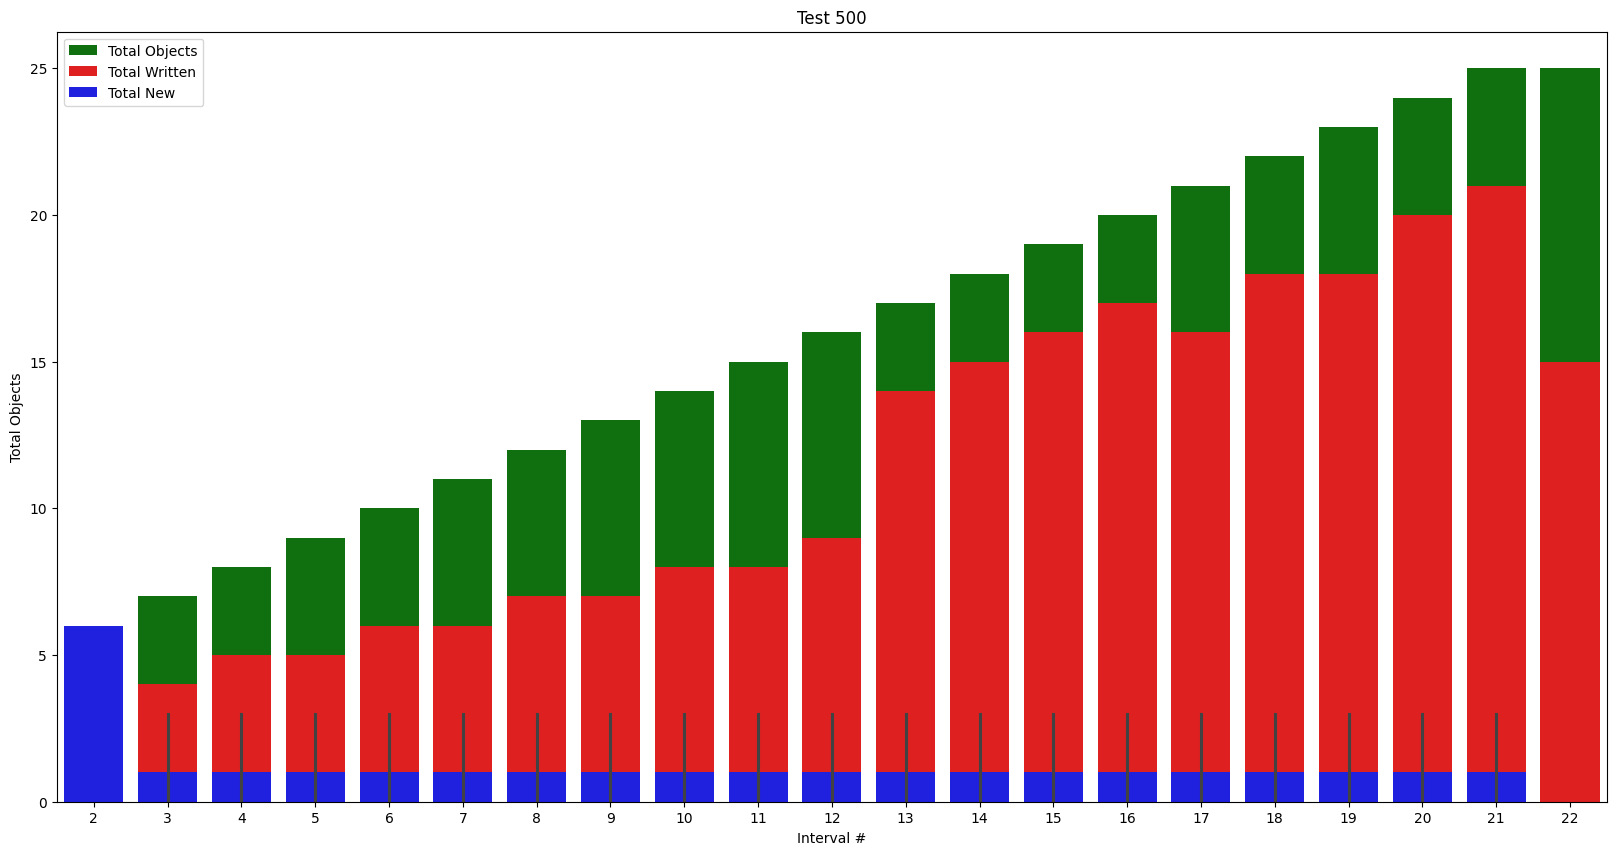

<Figure size 2000x2000 with 0 Axes>

In [25]:
# Now that we have the data, we can graph it
# For each test, we want to graph the following (with the interval # as the x-axis):
#   - The total number of objects (as the y-axis) subdivided into the following categories:
#      - Total number of objects
#      - New objects that interval
#      - Objects that were written to that interval
#
# The graph should be a stacked bar graph, with a segment for each object colored by the category it falls into
# The brightness of each segment should be proportional to the amount of memory saved by compressing the physical pages
# Draw a line through the segments corresponding to each object to show how long the object lived for

for test_number, allocation_data in test_allocation_data.items():
    # Get the data for each object
    objects = set()
    for allocation in allocation_data.values():
        for o in allocation.get_objects():
            objects.add(o)
    print("Test " + str(test_number))
    object_data = pd.DataFrame()

    min_interval = all_data[test_number]["Interval #"].min()
    max_interval = all_data[test_number]["Interval #"].max()

    total_objects_per_interval = [
        sum([1 for o in objects if o.get_first_interval() <= i and o.get_last_interval() >= i]) for i in range(min([o.get_first_interval() for o in objects]), max([o.get_last_interval() for o in objects]) + 1)
    ]

    for o in objects:
        savings = [
            row["Object Physical Page Compression Savings (bytes)"] for row in o.data
        ]
        savings_without_writes = [
            row["Object Physical Page Compression Savings (bytes)"] if not row["Written During This Interval?"] else 0 for row in o.data
        ]
        since_last_write = [i - o.get_interval_of_last_write(i) for i in range(o.get_first_interval(), o.get_last_interval() + 1)]
        object_data = pd.concat([object_data, pd.DataFrame({
            "Interval #": [row["Interval #"] for row in o.data],
            "Total Objects": [total_objects_per_interval[row["Interval #"] - min_interval] for row in o.data],
            "Total Written": [sum([1 for o in objects if o.get_first_interval() <= row["Interval #"] and o.get_last_interval() >= row["Interval #"] and o.was_written_to_during_interval(row["Interval #"])]) for row in o.data],
            "Total New": [sum([1 for o in objects if o.get_first_interval() <= row["Interval #"] and o.get_last_interval() >= row["Interval #"] and row["Is new?"]]) for row in o.data],
            "Written": [int(row["Written During This Interval?"]) for row in o.data],
            "New": [int(row["Is new?"]) for row in o.data],
            "Percent Savings": [
                # Zero if the object was written to, otherwise the amount of memory saved by compressing the physical pages
                row["Object Physical Page Compression Savings (bytes)"] / row["Object Physical Size (bytes)"] if not row["Written During This Interval?"] else 0 for row in o.data
            ],
            "Savings": savings,
            "Savings Without Writes": savings_without_writes,
            "Since Last Write * Savings": [prod(x) for x in zip(since_last_write, savings_without_writes)],
            "Since Last Write": since_last_write,
            "Longest Clean Streak": o.get_longest_lifetime_without_write(),
            "Clean Streak Savings": o.get_average_compression_during_longest_lifetime_without_write_in_bytes(),
            "Age": [i - o.get_first_interval() for i in range(o.get_first_interval(), o.get_last_interval() + 1)],
            "Object": repr(o),
            "Site": o.get_site(),
        })])
    print(object_data)


    # Plot the data
    # sns.barplot(x="Interval #", y="Total Objects", data=object_data, color="green", legend="full")
    # sns.barplot(x="Interval #", y="Total Written", data=object_data, color="red", legend="full")
    # sns.barplot(x="Interval #", y="Total New", data=object_data, color="blue", legend="full")

    # Create a multibar plot
    plt.figure(figsize=(20,10))
    plt.title("Test " + str(test_number))
    total_obj = sns.barplot(x="Interval #", y="Total Objects", data=object_data, color="green", label="Total Objects")
    total_hot = sns.barplot(x="Interval #", y="Total Written", data=object_data, color="red", label="Total Written")
    total_new = sns.barplot(x="Interval #", y="Total New", data=object_data, color="blue", label="Total New")
    # plt.legend(handles=[total_obj, total_hot, total_new], labels=["Total Objects", "Total Written", "Total New"])
    plt.show()
    # Show
    # sns.barplot(x="Interval #", y="Percent Savings", data=object_data, color="green", ax=ax)
    # sns.lineplot(x="Interval #", y="Written", data=object_data, ax=ax)
    plt.figure(figsize=(20,20))
    g = sns.relplot(
        data=object_data,
        x="Interval #", y="Since Last Write", kind="line", hue="Object", size="Savings", style="Written", markers=True, dashes=False
    )
    # Set the title
    g.fig.suptitle("Test " + str(test_number))
    # plt.legend()
    plt.show()

    plt.figure(figsize=(20,20))
    g = sns.relplot(
        data=object_data,
        x="Interval #", y="Since Last Write", kind="line", hue="Site", size="Savings", style="Written", markers=True, dashes=False
    )
    g.fig.suptitle("Test " + str(test_number))
    # plt.legend()
    plt.show()

    plt.figure(figsize=(20,20))
    plt.title("Test " + str(test_number))
    for o in objects:
        sns.lineplot(x="Interval #", y="Savings", data=object_data[object_data["Object"] == repr(o)], label=repr(o), style="Written", legend=False, markers={1: "X", 0: "D"}, dashes=False)
    plt.show()

    plt.figure(figsize=(20,20))
    plt.title("Test " + str(test_number))
    for o in objects:
        sns.lineplot(x="Interval #", y="Savings Without Writes", data=object_data[object_data["Object"] == repr(o)], label=repr(o), markers=True, dashes=False)
    plt.show()